### Dataset loader for the deep learning model training.

In [1]:
import os
import re
import torch
import glob
import rasterio as rio
import numpy as np 
import random
from utils.imgShow import imsShow
from utils.geotif_io import readTiff

In [2]:
# ----------Data paths-------------- 
pattern = re.compile(r'[a-zA-Z]\d_scene_(\d+)')
all_truth_paths = sorted(glob.glob('data/truth/*.gpkg'))

paths_truth_vec_tra = []
paths_truth_vec_val = []

paths_dem_tra = []
paths_dem_val = []

for path in all_truth_paths:
    filename = os.path.basename(path) 
    
    match = pattern.search(filename) 
    
    if match:
        scene_number_str = match.group(1) 
        scene_number = int(scene_number_str) 
        if scene_number >= 11:
            paths_truth_vec_val.append(path)
        else:
            paths_truth_vec_tra.append(path)

paths_scene_tra = [p.replace('.gpkg', '.tif').replace('truth', 'scene') for p in paths_truth_vec_tra]
paths_scene_val = [p.replace('.gpkg', '.tif').replace('truth', 'scene') for p in paths_truth_vec_val]

paths_tra_dem = [p.replace('.gpkg', '_DEM.tif').replace('truth', 'dem') for p in paths_truth_vec_tra]
paths_val_dem = [p.replace('.gpkg', '_DEM.tif').replace('truth', 'dem') for p in paths_truth_vec_val]

print(f"\nTotal files found: {len(all_truth_paths)}")
print(f"\nTraining scene image count: {len(paths_scene_tra)}")
print(f"Validation scene image count: {len(paths_scene_val)}")
print(paths_scene_tra[0])


Total files found: 65

Training scene image count: 50
Validation scene image count: 15
data/scene/S2_scene_01.tif


In [3]:
## create related functions
## - crop scene to patches
class crop:
    '''randomly crop corresponding to specific patch size'''
    def __init__(self, size=(256,256)):
        self.size = size
    def __call__(self, image, truth):
        '''size: (height, width)'''
        start_h = random.randint(0, truth.shape[0]-self.size[0])
        start_w = random.randint(0, truth.shape[1]-self.size[1])
        patch = image[:,start_h:start_h+self.size[0],start_w:start_w+self.size[1]]
        truth = truth[start_h:start_h+self.size[0], start_w:start_w+self.size[1]]
        return patch, truth
class Normalize:
    def __init__(self, max_bands, min_bands):
        self.max = max_bands  
        self.min = min_bands  
        
    def __call__(self, image):
        if isinstance(self.max, (int, float)):
            self.max = [self.max] * image.shape[-1]  
        if isinstance(self.min, (int, float)):
            self.min = [self.min] * image.shape[-1]         
        normalized = []
        for b in range(image.shape[-1]):  
            band = image[:, :, b].astype(float)  # 
            band_norm = (band - self.min[b]) / (self.max[b] - self.min[b] + 1e-6)
            normalized.append(band_norm)  
        # normalized = np.array(normalized)
        normalized = np.stack(normalized, axis=-1)  
        return np.clip(normalized, 0.0, 1.0)  

def calculate_histogram_params(band_data):
    clean_data = band_data[~np.isnan(band_data)].flatten() 
    if len(clean_data) == 0:
        return 0.0, 0.0  
    sorted_data = np.sort(clean_data)  
    n = len(sorted_data)  
    
    lower_idx = max(0, int(0.05 * n))  
    upper_idx = min(n-1, int(0.95 * n))  
    min_val = np.mean(sorted_data[:lower_idx+1]) if lower_idx > 0 else sorted_data[0] 
    max_val = np.mean(sorted_data[upper_idx:]) if upper_idx < n else sorted_data[-1]    
    return max_val, min_val  

def read_normalize(scene_arr):
    max_bands, min_bands = [], []
    for b in range(scene_arr.shape[-1]):
        max_val, min_val = calculate_histogram_params(scene_arr[:, :, b])
        max_bands.append(max_val)
        min_bands.append(min_val)
    
    normalizer = Normalize(max_bands, min_bands)
    scene_norm_arr = normalizer(scene_arr)
    
    scene_norm_arr[np.isnan(scene_norm_arr)] = 0
    
    return scene_norm_arr


In [4]:
### - Dataset definition
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths_scene, paths_truth, paths_dem=None, use_dem=False):
        self.paths_scene = paths_scene
        self.paths_truth = paths_truth
        self.paths_dem = paths_dem
        self.use_dem = use_dem

    def __getitem__(self, idx):
        # Load scene and truth image
        scene_path = self.paths_scene[idx]
        truth_path = self.paths_truth[idx]

        with rio.open(scene_path) as src:
            scene_arr = src.read().transpose((1, 2, 0))  # (H, W, C)

        if self.use_dem and self.paths_dem is not None:
            dem_path = self.paths_dem[idx]
            with rio.open(dem_path) as dem_src:
                dem_arr = dem_src.read(1)  # (H, W)
            dem_arr = dem_arr[:, :, np.newaxis]  # expand to (H, W, 1)
            scene_arr = np.concatenate([scene_arr, dem_arr], axis=-1)  # (H, W, C+1)

        with rio.open(truth_path) as truth_src:
            truth_arr = truth_src.read(1)  # (H, W)

        ## Pre-processing
        scene_arr = read_normalize(scene_arr)  # normalization
        scene_arr = scene_arr.astype(np.float32).transpose((2, 0, 1))  # (C, H, W)
        patch, truth = crop(size=(256, 256))(scene_arr, truth_arr)  # crop
        truth = truth[np.newaxis, :].astype(np.float32)  # (1, H, W)
        patch = torch.from_numpy(patch).float()
        truth = torch.from_numpy(truth).float()
        return patch, truth

    def __len__(self):
        return len(self.paths_scene)


In [5]:
## Create dataset instances
#use dem
tra_data = Dataset(paths_scene=paths_scene_tra, paths_truth=paths_scene_tra, paths_dem=paths_tra_dem, use_dem=True)
val_data = Dataset(paths_scene=paths_scene_val, paths_truth=paths_scene_val, paths_dem=paths_val_dem,use_dem=True)

# #Do not use DEM
# tra_data = Dataset(paths_scene=paths_scene_tra, paths_truth=paths_scene_tra, paths_dem=paths_tra_dem, use_dem=False)
# val_data = Dataset(paths_scene=paths_scene_val, paths_truth=paths_scene_val, paths_dem=paths_val_dem,use_dem=False)


torch.Size([7, 256, 256]) torch.Size([1, 256, 256])
training data size: 50
validation data size: 15


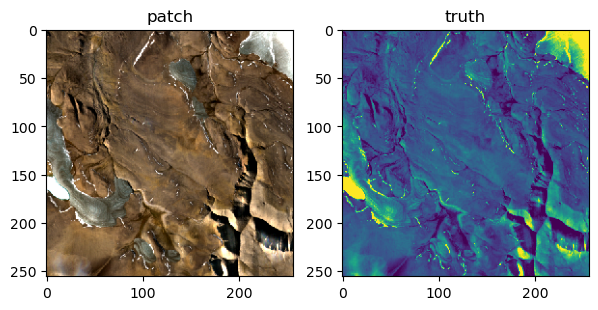

In [6]:
patch, truth = tra_data[0]
print(patch.shape, truth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([patch.numpy().transpose((1, 2, 0)), truth[0].numpy()], 
                        img_name_list=['patch', 'truth'], figsize=(7, 4))


In [7]:
### Create DataLoader
tra_loader = torch.utils.data.DataLoader(tra_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4)


torch.Size([4, 7, 256, 256]) torch.Size([4, 1, 256, 256])


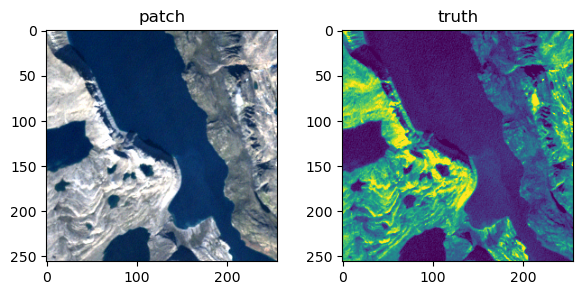

In [8]:
# for patch, truth in tra_loader:
#     print(patch.shape)
batch_patch, batch_truth = next(iter(tra_loader))
print(batch_patch.shape, batch_truth.shape)
patch_arr = batch_patch[0].numpy().transpose((1, 2, 0))
truth_arr = batch_truth[0].numpy().squeeze()
imsShow([patch_arr, truth_arr], img_name_list=['patch', 'truth'], figsize=(7, 3))
